In [235]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pathlib import Path

# Reading data and preprocessing

In [242]:
def preprocess_image(img, img_size=20):
    """Turn image from disk into a model-ready format (4-dimension)"""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale image
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32) # resize down to a small image
    img /= 255 # normalize to [0,1] range
    img = img[np.newaxis, ..., np.newaxis] # add batch dimension and color channel dimension
    return img

def read_and_plot_images(folder):
    images = []
    plt.figure(figsize=(20,10))
    for i, filename in enumerate(Path(folder).iterdir()):
        img = cv2.imread(str(filename))
        img = preprocess_image(img)
        images.append(img)
        plt.subplot(5, 10, i+1)
        plt.imshow(np.squeeze(img), cmap='gray')
    images = np.concatenate(images)
    plt.show()
    return images

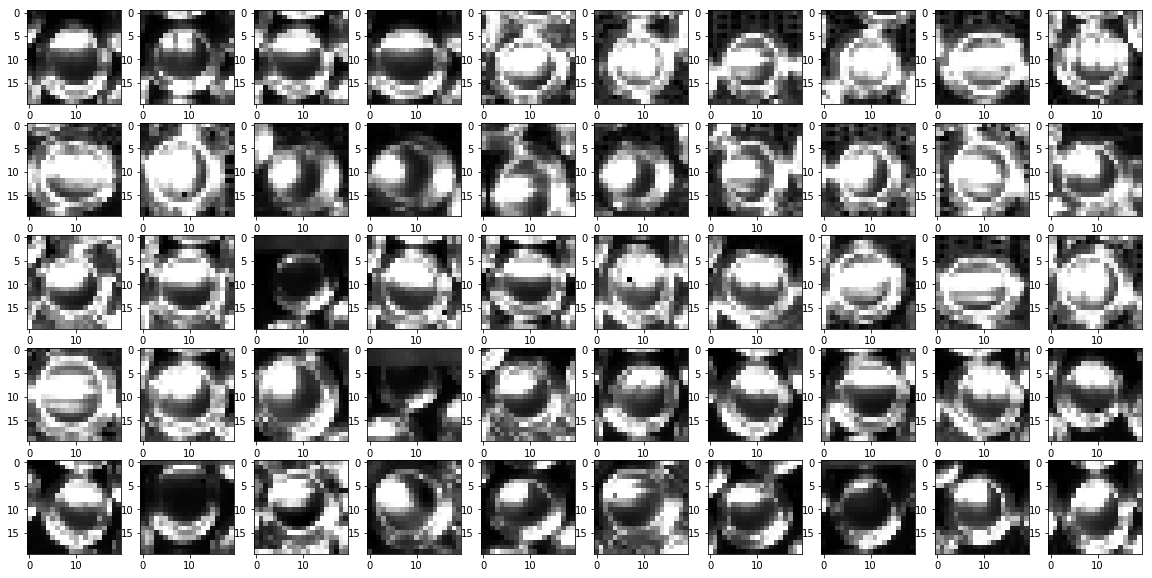

In [243]:
positive_images = read_and_plot_images('positive')

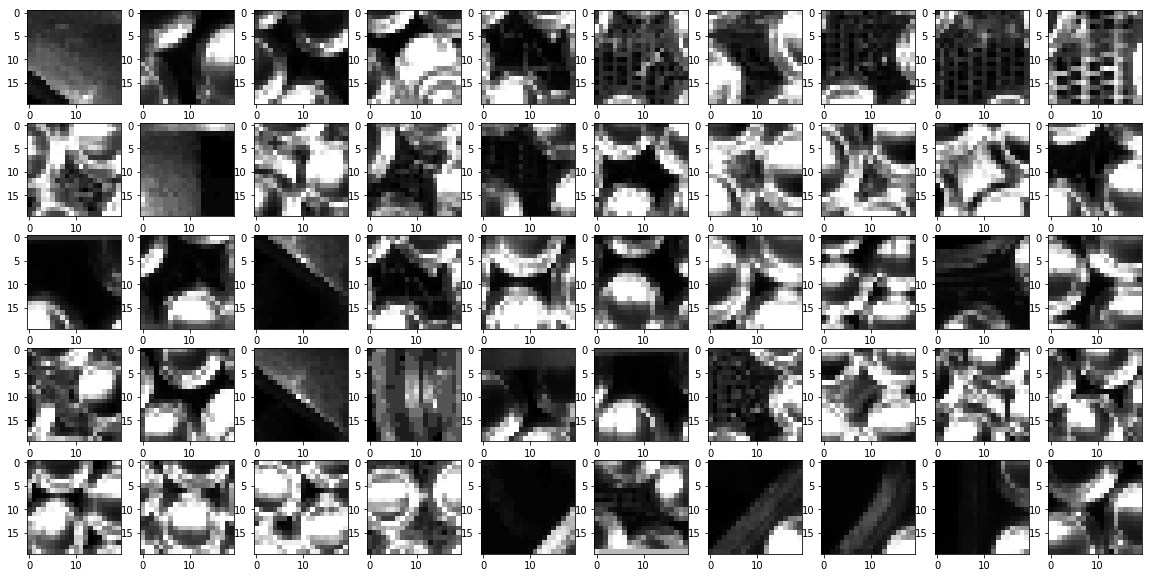

In [244]:
negative_images = read_and_plot_images('negative')

In [245]:
print(positive_images.shape, positive_images.dtype)
print(negative_images.shape, negative_images.dtype)

(50, 20, 20, 1) float32
(50, 20, 20, 1) float32


In [246]:
# join positive and negative together
X = np.concatenate([positive_images, negative_images])
y = np.concatenate([np.ones(positive_images.shape[0]),
                    np.zeros(negative_images.shape[0])])
print(X.shape, y.shape)

(100, 20, 20, 1) (100,)


# Train/Test split

In [281]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90, 20, 20, 1) (10, 20, 20, 1) (90,) (10,)


# Deep learning

In [329]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.summary()
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.input_shape, model.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 9, 9, 8)           80        
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_19 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 33        
Total params: 4,825
Trainable params: 4,825
Non-trainable params: 0
_________________________________________________________________
(None, 2

In [330]:
model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Train on 81 samples, validate on 9 samples
Epoch 1/30
81/81 [==============================] - 1s 13ms/step - loss: 0.7188 - acc: 0.4074 - val_loss: 0.6875 - val_acc: 0.5556
Epoch 2/30
81/81 [==============================] - 0s 123us/step - loss: 0.6899 - acc: 0.5556 - val_loss: 0.6717 - val_acc: 0.5556
Epoch 3/30
81/81 [==============================] - 0s 111us/step - loss: 0.6763 - acc: 0.6173 - val_loss: 0.6614 - val_acc: 0.7778
Epoch 4/30
81/81 [==============================] - 0s 123us/step - loss: 0.7020 - acc: 0.4444 - val_loss: 0.6548 - val_acc: 0.8889
Epoch 5/30
81/81 [==============================] - 0s 135us/step - loss: 0.6520 - acc: 0.7037 - val_loss: 0.6475 - val_acc: 0.8889
Epoch 6/30
81/81 [==============================] - 0s 123us/step - loss: 0.6610 - acc: 0.5926 - val_loss: 0.6388 - val_acc: 0.8889
Epoch 7/30
81/81 [==============================] - 0s 111us/step - loss: 0.6530 - acc: 0.6667 - val_loss: 0.6272 - val_acc: 0.8889
Epoch 8/30
81/81 [================

# Evaluation on test set

In [331]:
loss, acc = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", acc*100, '%')

10/10 [==============================] - 0s 200us/step
Loss: 0.1583961546421051
Accuracy: 100.0 %


# Detection

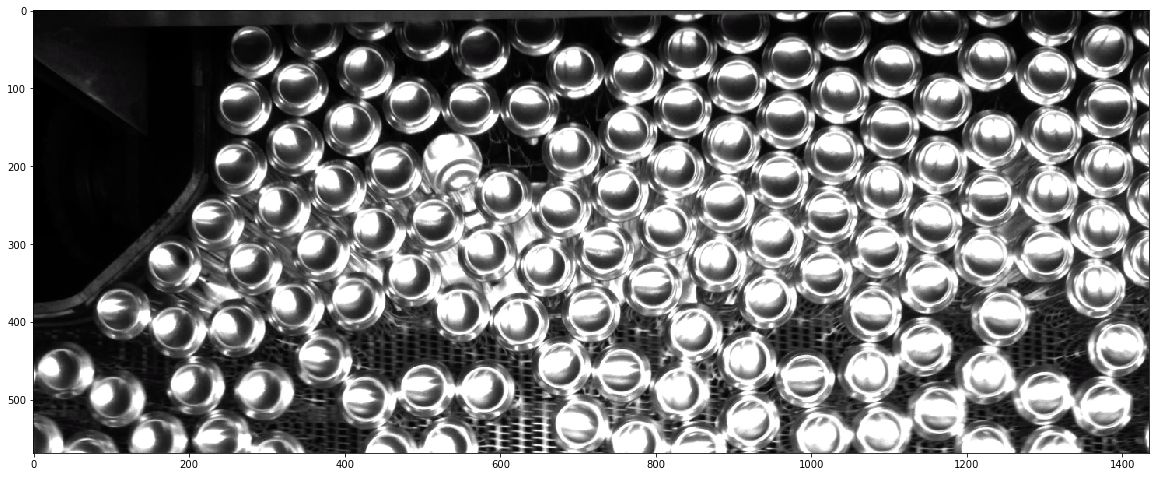

(569, 1435, 3)


In [332]:
image_path = 'img/cylinder.png'
big_img = cv2.imread(image_path)
plt.figure(figsize=(20,10))
plt.imshow(big_img)
plt.show()
print(big_img.shape)

In [333]:
crop_size = 80
strides = 20

In [334]:
%%time
X_candidate = [] # candidate image
candidate_rc = [] # candidate row and column
for r in range(0, big_img.shape[0], strides):
    for c in range(0, big_img.shape[1], strides):
        img = big_img[r:r+crop_size, c:c+crop_size]
        if img.shape[:2] != (crop_size, crop_size): # check if is boundary crop
            break
        img = preprocess_image(img)
        X_candidate.append(img)
        candidate_rc.append((r, c))
#         plt.imshow(img)
#         plt.show()
X_candidate = np.concatenate(X_candidate)
print(X_candidate.shape)

(1700, 20, 20, 1)
Wall time: 33.9 ms


In [335]:
%time pred_prob = model.predict(X_candidate)

threshold = 0.5 # confidence decision threshold
pred_binary = pred_prob >= threshold
positive_idx = np.where(pred_binary)[0]
print("Positive predictions:", np.count_nonzero(pred_binary))
print("Negative predictions:", np.count_nonzero(~pred_binary))

Wall time: 361 ms
Positive predictions: 229
Negative predictions: 1471


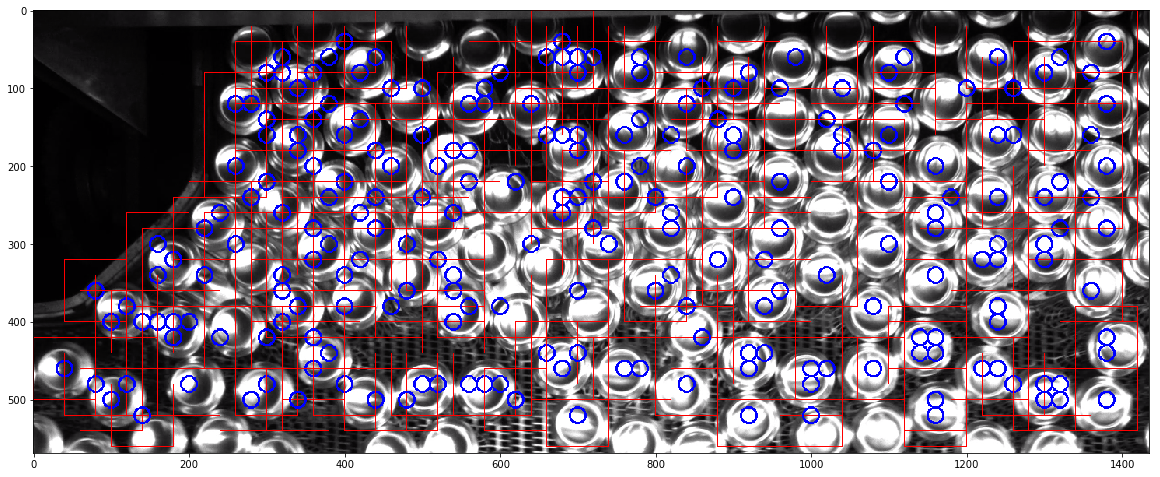

In [336]:
tmp_img = big_img.copy()
for idx in positive_idx:
    r, c = candidate_rc[idx]
    cv2.rectangle(tmp_img, (c,r), (c+crop_size, r+crop_size), (255, 0, 0), thickness=1)
    cv2.circle(tmp_img, (c+crop_size//2, r+crop_size//2), 10, (0, 0, 255), thickness=2)
plt.figure(figsize=(20,10))
plt.imshow(tmp_img)
plt.show()